In [1]:
%matplotlib inline

from __future__ import division
import os
import sys
from scipy import integrate
from scipy.interpolate import interp2d

import numpy as np
from numpy import pi,sin,cos,tan,e,arctan,arcsin,arccos,sqrt
from numpy.random import randn
import matplotlib
import matplotlib.pyplot as P


matplotlib.rcParams['figure.figsize'] = (7, 5)
P.rcParams['text.usetex'] = True  # not really needed
P.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
P.rcParams["font.size"] = 24
P.rc('xtick', labelsize=18) 
P.rc('ytick', labelsize=18)
# P.rc('xtick', labelsize=20) 
# P.rc('ytick', labelsize=20)
np.set_printoptions(threshold=np.nan)


sys.path.append("/Users/amadeus/Documents/10.semester/ma")
from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, W_tophat, T_obs, nutoz21, h
# from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, T_obs, nutoz21, h

sigma_8_BBKS = 0.833959881058


In [2]:
#preliminary, to be changed!!
bHI = 1
bgal = 1

lmin = 250; lmax = 25000 # lmin and lmax for Cl calculation
# lmin = 1; lmax = 1000 # lmin and lmax for Cl calculation
# ltab = np.arange(lmin,lmax)
# ltab = np.arange(lmin,lmax, 1000)
ltab = np.logspace(np.log10(lmin), np.log10(lmax), 10)


# ################################################
# # ZhangPen:
# zf = 0.75
# dzf = 0.25
# zfmin = zf - dzf; zfmax = zf + dzf

# zb = (1.5 + 1.9)/2
# dzb = 1.9 - zb
# zbmin = zb - dzb; zbmax = zb + dzb
# ################################################



################################################
zf = 0.3
dzf = 0.005
zfmin = zf - dzf; zfmax = zf + dzf

zb = 1.5
dzb = 0.01
zbmin = zb - dzb; zbmax = zb + dzb
################################################



# zf = .1
# dzf = 0.06
# zfmin = zf - dzf; zfmax = zf + dzf

# zb = .4
# dzb = 0.06
# zbmin = zb - dzb; zbmax = zb + dzb

print "foreground from {} to {}".format(zfmin, zfmax)
print "background from {} to {}".format(zbmin, zbmax)

foreground from 0.295 to 0.305
background from 1.49 to 1.51


Some functions as defined in Alkistis' notes:

In [3]:
def sg(z): #number count slope. Fit taken from eq 23 in 1611.01322v2
    n0 = 0.132
    n1 = 0.259
    n2 = 0.281
    n3 = 0.691
    n4 = 0.409
    n5 = 0.152
    
    return n0 + n1*z + n2*z**2 + n3*z**3 + n4*z**4 + n5*z**5
    


def g(z,zcenter, halfzwidth): #lensing kernel
    """zb is background redshift"""
    zmin = zcenter - halfzwidth
    zmax = zcenter + halfzwidth
    integral = integrate.quad(lambda zint: 
                              (rCom(zint) - rCom(z))/rCom(zint) * W_tophat(zint, zmin, zmax)
                              ,z
                              ,zmax,
                              full_output=1)[0]
    return rCom(z) * integral

#difficult to do quick integration because integration limit appears inside the integral:
# def g_cumtrapz(z, zb, dzb, NINT = 2000):
#     """zb is background redshift"""
#     zmin = zb - dzb
#     zmax = zb + dzb
#     z = np.atleast_1d(z)
#     if (z<1e-3).any() or (z>zmax).any():
#         raise ValueError("z lies outside the implemented range")
#     zint = np.linspace(1e-3, zmax, NINT)
#     integrand = (rCom(zint) - rCom(z))/rCom(zint) * W_tophat(zint, zmin, zmax)
#     result = cumtrapz(integrand, aaa, initial=0.)
#     val = interp1d(aaa[::-1], result[::-1], kind='linear', bounds_error=False)
#     return -c*val(a) #units: Mpc


def Cl_HIxmag_BBKS(ltable, zf, zb, delta_zf, Nint = 500):
    #note there is no T_obs factor because we want to compare with galaxy case
    fac1 = 3/2 * (H_0/c)**2 * Omega_m #no square on (H_0/c) because it cancels out
    fac2 = bHI * (5*sg(zb) - 2)
    zmin = zf - delta_zf
    zmax = zf + delta_zf
    ztab = np.linspace(zmin, zmax, Nint) #do checks on this! should be 0 to inf
    gtab = [g(zz, zb, dzb) for zz in ztab] # this is slow
    
    integrand=np.zeros([len(ztab),len(ltable)])
    for il in range(len(ltable)):
        ell = ltable[il]
        integrand[:,il]= (1+ztab) * W_tophat(ztab, zfmin, zfmax) * gtab / rCom(ztab)**2 * P_cdm_BBKS(( ell)/rCom(ztab)) * D_z(ztab)**2
    result= fac1 * fac2 * np.trapz(integrand,ztab,axis=0)
    return result

def Cl_HIxmag_CAMB(ltable, zf, zb, delta_zf, Nint = 500):
    #note there is no T_obs factor because we want to compare with galaxy case
    fac1 = 3/2 * bHI*(H_0/c)**2 * Omega_m #no square on (H_0/c) because it cancels out
    fac2 = bHI * (5*sg(zb) - 2)
    zmin = zf - delta_zf
    zmax = zf + delta_zf
    ztab = np.linspace(zmin, zmax, Nint) #do checks on this! should be 0 to inf
    
    integrand=np.zeros([len(ztab),len(ltable)])
    for il in range(len(ltable)):
        ell = ltable[il]
        integrand[:,il]= np.array([(1+zzz) * W_tophat(zzz, zfmin, zfmax) * g(zzz, zb, dzb) / rCom(zzz)**2 * pknl(( ell)/rCom(zzz), zzz) for zzz in ztab])
#         integrand[:,il]= np.array([(1+zzz) * W_tophat(zzz, zfmin, zfmax) * g(zzz, zb, dzb) * rCom(zzz) * pknl(( ell)/rCom(zzz), zzz) for zzz in ztab]) #different factor of chi than in alkistis' notes (units are wrong there)
    result= fac1 * fac2 * np.trapz(integrand,ztab,axis=0)
    return result
    
                        

In [4]:
# zf = 0.5
# delta_zf = 0.01
# Nint = 500
# ell = 100

# zmin = zf - delta_zf
# zmax = zf + delta_zf
# ztab = np.linspace(zmin, zmax, Nint) #do checks on this! should be 0 to inf


From ZiourHui:

In [5]:
#two ways to compute the same thing:

def Cl_delkap2_BBKS(ltable, zf, zb, delta_zf, Nint = 500):
    fac = bHI * (5*sg(zb) - 2)
    return Cl_HIxmag_BBKS(ltable, zf, zb, delta_zf, Nint = Nint) / fac

def Cl_delkap_BBKS(ltable, zf, zb, delta_zf, Nint = 500):
    fac = 3/2 * (H_0/c)**2 * Omega_m
    
    zmin = zf - delta_zf
    zmax = zf + delta_zf
    ztab = np.linspace(zmin, zmax, Nint) #do checks on this! should be 0 to inf
    gtab = [g(zz, zb, dzb) for zz in ztab] # this is slow
    
    integrand=np.zeros([len(ztab),len(ltable)])
    for il in range(len(ltable)):
        ell = ltable[il]
        integrand[:,il]= (1+ztab) * W_tophat(ztab, zfmin, zfmax) * gtab / rCom(ztab)**2 * P_cdm_BBKS(( ell)/rCom(ztab)) * D_z(ztab)**2
    result= fac * np.trapz(integrand,ztab,axis=0)
    return result




def Cl_delkap2_CAMB(ltable, zf, zb, delta_zf, Nint = 500):
    fac = bHI * (5*sg(zb) - 2)
    return Cl_HIxmag_CAMB(ltable, zf, zb, delta_zf, Nint = Nint) / fac

def Cl_delkap_CAMB(ltable, zf, zb, delta_zf, Nint = 500):
    fac = 3/2 * (H_0/c)**2 * Omega_m
    
    zmin = zf - delta_zf
    zmax = zf + delta_zf
    ztab = np.linspace(zmin, zmax, Nint) #do checks on this! should be 0 to inf
    gtab = [g(zz, zb, dzb) for zz in ztab] # this is slow
    
    integrand=np.zeros([len(ztab),len(ltable)])
    for il in range(len(ltable)):
        ell = ltable[il]
        integrand[:,il]= [(1+zzz) * W_tophat(zzz, zfmin, zfmax) * gtab / rCom(zzz)**2 * pknl(( ell)/rCom(zzz), zzz) for zzz in ztab]
    result= fac * np.trapz(integrand,ztab,axis=0)
    return result

Galaxy and HI autocorrelation Cls:

In [6]:
def C_l_HIHI_BBKS(ltable,zmin,zmax, Nint = 500):
    """arguments: ell array, zmin, zmax
    returns: Cl as array"""
    ztable = np.linspace(zmin, zmax, Nint)
    integrand=np.zeros([len(ztable),len(ltable)])
    for l in range(len(ltable)):
        #for the moment we divide out T_obs to compare with the galaxy results
        integrand[:,l]=E_z(ztable)*(W_tophat(ztable,zmin,zmax)*D_z(ztable)/rCom(ztable))**2*P_cdm_BBKS((ltable[l])/rCom(ztable))
    result=bHI* H_0/c*np.trapz(integrand,ztable,axis=0)
    return result


def C_l_gg_BBKS(ltable,zmin,zmax, Nint = 500):
    """arguments: ell array, zmin, zmax
    returns: Cl as array"""
    ztable = np.linspace(zmin, zmax, Nint)
    integrand=np.zeros([len(ztable),len(ltable)])
    for l in range(len(ltable)):
        integrand[:,l]=E_z(ztable)*(W_tophat(ztable,zmin,zmax)*D_z(ztable)/rCom(ztable))**2*P_cdm_BBKS((ltable[l])/rCom(ztable))
    result=bgal* H_0/c*np.trapz(integrand,ztable,axis=0)
    return result


Interpolate the nonlinear P(k) from Alkistis and use it to calculate Cls:

In [7]:
pknl_root = "./PkNL/"
filelist =  np.sort(os.listdir(pknl_root))
print "CHECK IF THIS IS IN ORDER:"
print filelist
zc_pk = np.linspace(0,4,len(filelist))
# print zc_pk

k_pk = np.loadtxt(pknl_root + filelist[0], unpack = True)[0]

pknl_arr = np.array([ np.loadtxt(pknl_root + fi, unpack = True)[1] for fi in filelist ])

pknl_int = interp2d( k_pk, zc_pk, pknl_arr)

def pknl(kk, zz):
    res = pknl_int(kk/h, zz)/h**3
    if len(res) == 1:
        return res[0]
    else:
        return res

    

# #test it:

# for zi in range(len(zc_pk)):
#     for ki in range(len(k_pk)):
#         pppk_at_z = np.array( np.loadtxt(pknl_root + filelist[zi], unpack = True)[1])
#         print pppk_at_z[ki] - pknl(k_pk[ki], zc_pk[zi])



def C_l_HIHI_CAMB(ltable,zmin,zmax, Nint = 500):
    """arguments: ell array, zmin, zmax
    returns: Cl as array"""
    ztable = np.linspace(zmin, zmax, Nint)
    integrand=np.zeros([len(ztable),len(ltable)])
    for l in range(len(ltable)):
        #for the moment we divide out T_obs to compare with the galaxy results
#         integrand[:,l]=E_z(ztable)*(W_tophat(ztable,zmin,zmax)/rCom(ztable))**2*pknl((ltable[l])/rCom(ztable), ztable)
        integrand[:,l]= np.array([E_z(zzz)*(W_tophat(zzz,zmin,zmax)/rCom(zzz))**2*pknl((ltable[l])/rCom(zzz), zzz) for zzz in ztable])
    result=bHI* H_0/c*np.trapz(integrand,ztable,axis=0)
    return result

def C_l_gg_CAMB(ltable,zmin,zmax, Nint = 500):
    """arguments: ell array, zmin, zmax
    returns: Cl as array"""
    ztable = np.linspace(zmin, zmax, Nint)
    integrand=np.zeros([len(ztable),len(ltable)])
    for l in range(len(ltable)):
        integrand[:,l]=np.array([E_z(zzz)*(W_tophat(zzz,zmin,zmax)/rCom(zzz))**2*pknl((ltable[l])/rCom(zzz), zzz) for zzz in ztable])
    result=bgal* H_0/c*np.trapz(integrand,ztable,axis=0)
    return result


CHECK IF THIS IS IN ORDER:
['Pk_z0.dat' 'Pk_z0p2.dat' 'Pk_z0p4.dat' 'Pk_z0p6.dat' 'Pk_z0p8.dat'
 'Pk_z1.dat' 'Pk_z1p2.dat' 'Pk_z1p4.dat' 'Pk_z1p6.dat' 'Pk_z1p8.dat'
 'Pk_z2.dat' 'Pk_z2p2.dat' 'Pk_z2p4.dat' 'Pk_z2p6.dat' 'Pk_z2p8.dat'
 'Pk_z3.dat' 'Pk_z3p2.dat' 'Pk_z3p4.dat' 'Pk_z3p6.dat' 'Pk_z3p8.dat'
 'Pk_z4.dat']


Signal to noise:

In [8]:
def DELTA_Cl_HIxmag(ltable, zf, dzf, zb, dzb, PERFECT_SURVEY = 1, BBKS = False):
    zfmin = zf - dzf; zfmax = zf+dzf
    zbmin = zb-dzb; zbmax = zb+dzb
    
    if BBKS:
        ClHIHIfunc = C_l_HIHI_BBKS
        Cl_HIxmagfunc = Cl_HIxmag_BBKS
        Clggfunc = C_l_gg_BBKS
    else:
        ClHIHIfunc = C_l_HIHI_CAMB
        Cl_HIxmagfunc = Cl_HIxmag_CAMB
        Clggfunc = C_l_gg_CAMB
    
    #perfect survey:
    if PERFECT_SURVEY:
        Cshot = np.zeros(len(ltable)); N_ell = np.zeros(len(ltable)); 
        fsky = 1; d_ell = 1;
    
    else:
        return ValueError("only perfect survey implemented")
    X2 = Cl_HIxmagfunc(ltable, zf, zb, dzf)**2
    HIHI = ClHIHIfunc(ltable, zfmin, zfmax) + Cshot
    gg = Clggfunc(ltable, zbmin, zbmax) + N_ell
    num = X2 + HIHI*gg
    denom = (2*ltable+1) * d_ell * fsky
    return np.sqrt(num/denom)

def S2N(ltable, zf, dzf, zb, dzb, PERFECT_SURVEY = 1):
    delt = DELTA_Cl_HIxmag(ltable, zf, dzf, zb, dzb, PERFECT_SURVEY = PERFECT_SURVEY)
    signal = Cl_HIxmag(ltable, zf, zb, dzb)
    return signal/delt

Compare HIHI Cls with Fig 2 in Bingo paper:

In [9]:
#compare with Fig 2 in Bingo paper:
lbing = np.arange(1,1000)

Cl_HIHI = C_l_HIHI_BBKS(lbing, nutoz21(975), nutoz21(925))
Cl_HIHI_camb = C_l_HIHI_CAMB(lbing, nutoz21(975), nutoz21(925))

fig = P.figure(); ax = fig.add_subplot(111);
ax.loglog(lbing, Cl_HIHI*(lbing+1)*lbing / 2 / pi)
ax.loglog(lbing, Cl_HIHI_camb*(lbing+1)*lbing / 2 / pi)

P.show()

KeyboardInterrupt: 

which matches perfectly (BBKS case). The CAMB power spectrum seems to have different normalization... check sigma_8 maybe?
Now plotting the HI-mag Cls from Alkistis' notes:

In [10]:

Cl_Hxm_tab = Cl_HIxmag_CAMB(ltab, zf, zb, dzf)
# Cl_Hxm_tab2 = Cl_HIxmag_CAMB(ltab, zf, zb, dzf) #delete later



# Cl_dxk_tab = Cl_delkap_CAMB(ltab, zf, zb, dzf)
# Cl_gg = Cl_BBKS_gg(ltab, zfmin, zfmax)

(0.0001, 0.5)

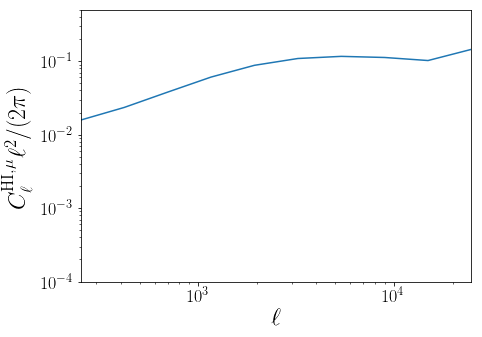

In [11]:
fig = P.figure(); ax = fig.add_subplot(111);
# ax.loglog(ltab, Cl_Hxm_tab*ltab**2 / 2 / pi)
ax.loglog(ltab, Cl_Hxm_tab*ltab**2 / 2 / pi)
# ax.loglog(ltab, Cl_dxk_tab, ls = ':', color = 'black')
# ax.loglog(ltab, Cl_dxk2_tab, ls = '-.', color = 'pink')
ax.set_xlabel("$\ell$")
ax.set_ylabel("$C_\ell^\mathrm{HI, \mu} \ell^2/(2\pi)$")
# ax.plot(ltab, Cl_Hxm*ltab**2/2/pi)
# ax.set_xlim((10,1000))
ax.set_xlim((250,25000))
ax.set_ylim((1e-4, 5e-1))
# ax.set_ylim((1e-9, 2e-7))

I think our $C_\ell^\mathrm{HI, mag}$ should match $C_\ell^{\mu g}$ Fig. 5 in Zhang&Pen up to a constant factor... The $\ell$ dependence is totally different if we use BBKS, but not if we use CAMB. We still have are about a factor of 10 wrong...

Their $\ell$ dependece is $C_\ell^{\mu g} \sim \Delta_m^2(\ell/r(z_f), z_f) / l^3$.

For us it's $C_\ell^\mathrm{HI, mag} \sim P((\ell + 1/2)/r(z),z))$. Here I used the fit from BBKS: $P_m^\mathrm{BBKS}(k) = Ak^{n_s}T_\mathrm{BBKS}(k)$ and thus $P_m^\mathrm{BBKS}(k) \mathrm D^2(z) = P(k,z)$ with the growth factor $D$. As far as I know usual conventions are $P \sim k^3 \Delta$, so where does the $\Delta^2$ come from? I guess it's just another convention but haven't checked yet.

NOW: signal to noise for perfect survey:

In [42]:
zfs = np.linspace(0.8,zb - 2*dzb,10)
dzf = 0.05

ltab = np.array([ 100,500,1000])

S2N_p_tab = []
Delta_Cl_p_tab = []
for zzf in zfs:
    print zzf-dzf, zzf+dzf

    S2N_p_tab.append( S2N(ltab, zzf, dzf, zb, dzb, PERFECT_SURVEY=1) )
    Delta_Cl_p_tab.append( DELTA_Cl_HIxmag(ltab, zzf, dzf, zb, dzb, PERFECT_SURVEY=1))
    
print zb-dzb, zb+dzb


0.75 0.85
0.816666666667 0.916666666667
0.883333333333 0.983333333333
0.95 1.05
1.01666666667 1.11666666667
1.08333333333 1.18333333333
1.15 1.25
1.21666666667 1.31666666667
1.28333333333 1.38333333333
1.35 1.45
1.6 2.0


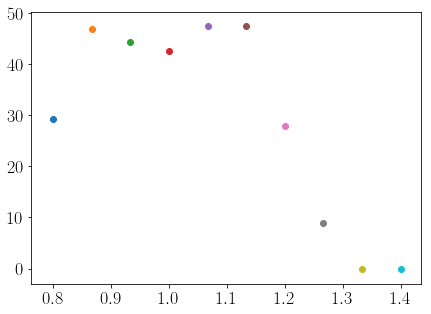

In [43]:
ztab = np.linspace(zfs[0], zfs[1])

fig = P.figure(); ax = fig.add_subplot(111);
for zi in range(len(zfs)):
    zz = zfs[zi]
    ax.scatter(zz,S2N_p_tab[zi][1])
    

Text(0.5,0,u'$\\ell$')

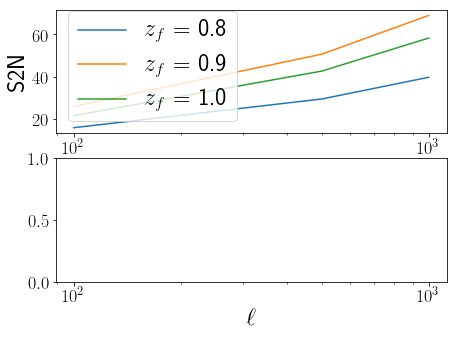

In [27]:
fig = P.figure(); ax1 = fig.add_subplot(211); 
ax2 = fig.add_subplot(212, sharex = ax1);
for i in range(len(S2N_p_tab)):
    ax1.semilogx(ltab, S2N_p_tab[i], label = "$z_f$ = {}".format(zfs[i]))
# ax1.axhline(1, label = "$1$")
# ax1.set_ylim((0, 11))
ax1.set_ylabel("S2N")
ax1.legend()


# ax2.loglog(ltab, Cl_Hxm, label = "$C_\ell^{HI,\mu}$")
# ax2.loglog(ltab, Delta_Cl_p_tab, color = 'black', label = "$\Delta C_\ell^{HI,\mu}$")
ax2.legend(loc = "upper right")

ax2.set_xlabel("$\ell$")


In [28]:
for i in range(len(S2N_p_tab)):
    print S2N_p_tab[i]

[ 15.71335386  29.35503242  39.65062724]
[ 25.85118589  50.61053124  68.99333429]
[ 21.45074302  42.59229076  58.27130498]
